# 数字の画像識別AIをつくろう


手書き数字の画像のデータセットMNISTを使用して、画像から数字を推論する機械学習モデルを作ります。

### 手順

1. データセットのダウンロードと変換
1. データローダーの作成
1. 機械学習モデルの実装
1. 学習
1. 評価

In [ ]:
import torch
import torchvision

In [ ]:
# Google Colabの場合、右上のランタイムの設定でT4を選択
# GPUが利用可能かを確認
torch.cuda.is_available()

True

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## 1.データセットのダウンロードと変換

In [21]:
# 今回は手書き数字のデータセットであるMNISTを使用する

# データを変換するための関数を定義
transform = torchvision.transforms.Compose([
    # PIL画像をテンソルに変換
    torchvision.transforms.ToTensor(),
    # MNISTデータセットの平均と標準偏差を使って正規化し、平均0、標準偏差1に変換
    # 正規化することで学習が安定する
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# VisionDatasetを使用すると様々なデータセットをダウンロードできる
# https://pytorch.org/vision/main/datasets.html

# 訓練データ
train_dataset = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)

# テストデータ
test_dataset = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=transform
)

print("サンプル数", len(train_dataset), len(test_dataset))
type(train_dataset)

# サンプル数はそれぞれ6万件と1万件

サンプル数 60000 10000


torchvision.datasets.mnist.MNIST

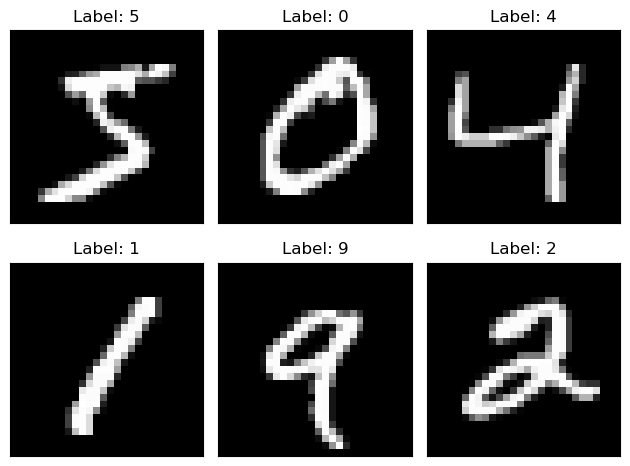

In [15]:
# 訓練データの画像をmatplitlibで試しに表示してみる

fig = plt.figure()

for i in range(6):
    # 2行3列のグリッドのi+1番目を描画
    plt.subplot(2, 3, i + 1)
    # 画像のテンソルを取得
    image_tensor = train_dataset[i][0]
    # -0.5 ~ 0.5 -> 0 ~ 1 に変換
    unnormalized_image = image_tensor / 2 + 0.5
    # (1, 28, 28) -> (28, 28, 1) に変換
    # (Channel, Hight, Width) -> (Hight, Width, Channel)
    permuted = unnormalized_image.permute(1, 2, 0)

    plt.title(f"Label: {train_dataset[i][1]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.imshow(permuted, cmap="gray")

# 2.データーローダーの作成

In [20]:
# データーローダーとは、学習時にサンプルのまとまり（バッチ）ごとにデータを読み込むためのオブジェクト

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("サンプル数", len(train_dataset), len(test_dataset))
print("バッチ数", len(train_loader), len(test_loader))
print("バッチサイズ(1バッチあたりのサンプル数)", train_loader.batch_size, test_loader.batch_size)
type(train_loader)

サンプル数 60000 10000
バッチ数 938 10
バッチサイズ(1バッチあたりのサンプル数) 64 1000


torch.utils.data.dataloader.DataLoader

# 3.機械学習モデルの実装

In [22]:
# 実装のイメージ
# https://miro.medium.com/v2/resize:fit:3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png

import torch.nn as nn
import torch.nn.functional as F

# 機械学習モデルを実装する場合、まずnn.Moduleを継承したクラスを作成する
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
class Net(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(Net, self).__init__()

        # 畳み込み層(convolution)の定義
        # フィルターを使って画像の特徴を抽出するための層
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # ドロップアウトの定義
        # ドロップアウトは過学習を防ぐための手法
        # https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#dropout2d
        self.conv2_drop = nn.Dropout2d()

        # 全結合層の定義
        # 畳み込み層で抽出した特徴を元に、最終的な出力（数字ごとの確率）を行う層
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, debug=False):
        if debug: print(f"入力データの次元: {x.shape}")

        # 1x28x28 -> 10x24x24に畳み込み
        x = self.conv1(x)
        if debug: print(f"畳み込み１層後: {x.shape}")

        # 10x24x24 -> 10x12x12にプーリング
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング１層後: {x.shape}")

        # ReLU活性化関数を適用
        x = F.relu(x)

        # 10x12x12 -> 20x8x8に畳み込み
        x = self.conv2(x)
        if debug: print(f"畳み込み２層後: {x.shape}")

        # ドロップアウトを適用
        x = self.conv2_drop(x)

        # 20x8x8 -> 20x4x4にプーリング
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング２層後: {x.shape}")

        # ReLU活性化関数を適用
        x = F.relu(x)

        # 20x4x4 -> 320 の1次元テンソルに変換
        x = x.view(-1, 320)
        if debug: print(f"1次元テンソルに変換後: {x.shape}")

        # 320 -> 50 の1次元テンソルに変換
        x = self.fc1(x)
        if debug: print(f"全結合層１後: {x.shape}")

        # ReLU活性化関数
        x = F.relu(x)

        # ドロップアウトを適用
        x = F.dropout(x, training=self.training)

        # 50 -> 10 の1次元テンソルに変換
        x = self.fc2(x)
        if debug: print(f"全結合層２後: {x.shape}")

        # ソフトマックス関数でロジットを確率に変換
        return F.log_softmax(x, dim=1)

Net()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [24]:
# パラメータの確認

# モデルのインスタンス化
model = Net()

# GPUかCPUかを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPUの場合はモデルをGPUに転送
model.to(device)

print("\n各層のパラメータ:")
total_params = 0
for name, param in model.named_parameters():
    print(f"{name}: {np.prod(param.size())}個 {param.device}に存在")
    total_params += param.numel()

print(f"\n合計パラメータ数: {total_params}個")


各層のパラメータ:
conv1.weight: 250個 cuda:0に存在
conv1.bias: 10個 cuda:0に存在
conv2.weight: 5000個 cuda:0に存在
conv2.bias: 20個 cuda:0に存在
fc1.weight: 16000個 cuda:0に存在
fc1.bias: 50個 cuda:0に存在
fc2.weight: 500個 cuda:0に存在
fc2.bias: 10個 cuda:0に存在

合計パラメータ数: 21840個


## 4.学習

In [25]:
from torch.optim import SGD

def train(num_epochs=1, debug=False):
    model = Net().to(device)

    # 損失関数を定義
    # 今回使用する損失関数は確率的勾配降下法（Stochstic Gradient Descent）
    # 誤差が最小になるように少しずつパラメータを更新する方法
    # https://optimization.cbe.cornell.edu/images/f/f8/Visualization_of_stochastic_gradient_descent.png
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)

    # ログ
    train_log_x = []
    train_log_y = []
    test_log_x = []
    test_log_y = []

    # エポックはデータセットを周回する回数
    for epoch in range(num_epochs):
        if not debug: print(f"エポック: {epoch + 1}")

        # 学習データからバッチを読み込む（今回は1000バッチ程度）
        for batch_index, (data, target) in enumerate(train_loader):
            # 勾配（予測と正解の差分の傾き）を計算する学習モードに設定
            model.train()

            # 勾配を初期化
            optimizer.zero_grad()

            # データをGPUに転送
            data, target = data.to(device), target.to(device)

            # モデルにデータを入力して予測
            output = model(data, debug=debug)

            # 損失（予測と正解の差分）を計算
            # 今回は負の対数尤度損失関数（Negative Loss Likelihood）を使用
            loss = F.nll_loss(output, target)

            # 全ての層の勾配を計算
            loss.backward()

            # 全ての層のパラメータを更新
            optimizer.step()

            # 100バッチごとに進捗を表示
            if batch_index % 100 == 0 and not debug:
                data_num = batch_index * len(data)
                dataset_data_num = len(train_loader.dataset)
                total_trained = data_num + epoch * dataset_data_num
                train_log_x.append(total_trained)
                train_log_y.append(loss.item())
                print(f"バッチ:{batch_index}, データ:{data_num}/{dataset_data_num}, 損失: {loss.item()}")

                # モデルを保存
                model_file_path = f"./model.path"
                optimizer_file_path = "./optimizer.pth"
                torch.save(model.state_dict(), model_file_path)
                torch.save(optimizer.state_dict(), optimizer_file_path)
                print(f"モデルを保存しました: {model_file_path}")
                print(f"オプティマイザを保存しました: {optimizer_file_path}")

            if debug: return

        # エポック毎にテストデータで評価
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            # テスト用のデータローダーからバッチを読み込む（10バッチ）
            for data, target in test_loader:

                # GPUに転送
                data = data.to(device)
                target = target.to(device)

                # 推論
                output = model(data)

                # 損失を計算し、蓄積
                test_loss += F.nll_loss(output, target, reduction="sum").item()

                # もっとも確率の高いクラスを抽出
                pred = output.data.max(1, keepdim=True)[1]

                # 抽出したクラスと正解を比較し、正解数をカウント
                correct += pred.eq(target.data.view_as(pred)).sum()

        # サンプル数で割って平均損失を計算
        test_loss /= len(test_loader.dataset)

        # ログを保存
        test_log_x.append(epoch * len(train_loader.dataset))
        test_log_y.append(test_loss)
        print(f"テストデータでの損失:{test_loss}, 正解率: ({int(100. * correct / len(test_loader.dataset))}%)")

    # ログをプロット
    plt.figure()
    plt.plot(train_log_x, train_log_y, label="train", color="blue")
    plt.scatter(test_log_x, test_log_y, label="test", color="red")
    plt.legend(["train", "test"])
    plt.xlabel("Number of training data")
    plt.ylabel("Negative log likelihood loss")


In [27]:
# 1エポックでテスト
train(1, debug=True)

# 64はバッチサイズ

入力データの次元: torch.Size([64, 1, 28, 28])
畳み込み１層後: torch.Size([64, 10, 24, 24])
プーリング１層後: torch.Size([64, 10, 12, 12])
畳み込み２層後: torch.Size([64, 20, 8, 8])
プーリング２層後: torch.Size([64, 20, 4, 4])
1次元テンソルに変換後: torch.Size([64, 320])
全結合層１後: torch.Size([64, 50])
全結合層２後: torch.Size([64, 10])


エポック: 1
バッチ:0, データ:0/60000, 損失: 2.2753357887268066
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:100, データ:6400/60000, 損失: 2.1562516689300537
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:200, データ:12800/60000, 損失: 1.2390906810760498
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:300, データ:19200/60000, 損失: 0.7488577365875244
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:400, データ:25600/60000, 損失: 0.6169015765190125
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:500, データ:32000/60000, 損失: 0.5897001028060913
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:600, データ:38400/60000, 損失: 0.6093674302101135
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:700, データ:44800/60000, 損失: 0.3918871283531189
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:800, データ:51200/60000, 損失: 0.661591112613678
モデルを保存しました: ./model.path
オプティマイザを保存しました: ./optimizer.pth
バッチ:900, データ:57600/60000, 損失: 0.45826646685600

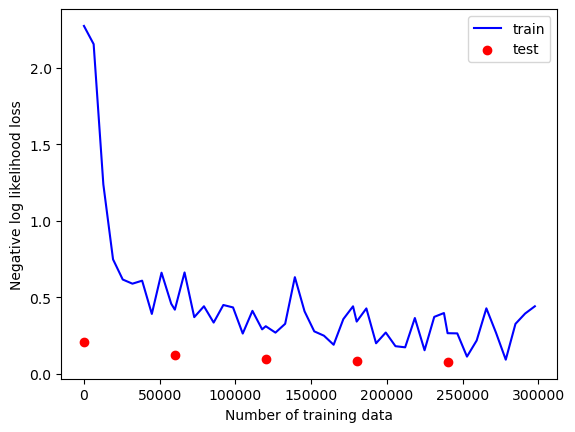

In [28]:
# 学習開始
train(num_epochs=5)

# 正解率は97%程度

## 5.評価

/tmp/ipykernel_2461202/183971862.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


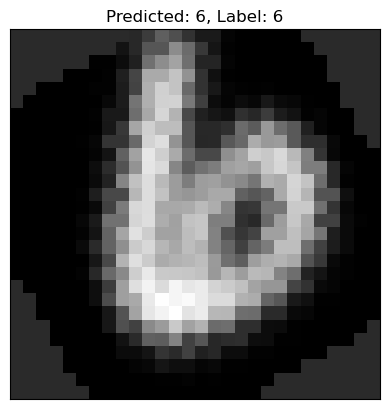

In [29]:
# ランダムに画像を選び変形して予測

import random

def evaluate():
    # ランダムにデータを取得
    random_index = random.randint(0, len(test_dataset) - 1)
    data = test_dataset[random_index]

    # ガウシアンノイズを乗せて画像を回転する関数を作成
    augument_sample = torchvision.transforms.Compose([
        torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3)),
        torchvision.transforms.RandomRotation(degrees=(0, 60)),
    ]);


    # 画像を変換
    image_tensor = augument_sample(data[0])

    # モデルの推論様に前処理する関数を作成
    # 28x28にリサイズし、白黒に変換、正規化（平均0、分散1）
    transform_sample = torchvision.transforms.Compose([
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # 関数を適用
    transformed = transform_sample(image_tensor)

    # モデルを作成し、GPUに転送
    model = Net().to(device)

    # モデルをロード（省略可能）
    model.load_state_dict(torch.load("./model.pth"))

    # 評価モードに設定（勾配を計算しない）
    model.eval()

    # 推論しロジットを出力
    prediction = model(transformed.unsqueeze(0).to(device))

    # ノイズを乗せて回転された画像を表示
    image_numpy = image_tensor.squeeze().cpu().detach().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_numpy, cmap="gray")

    # 推論結果を表示
    plt.title(f"Predicted: {prediction.argmax().item()}, Label: {data[1]}")

evaluate()